In [32]:
import os
import sys
import torch
import torch.nn.functional as F
import clip
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Get the absolute path to the project root directory (parent of both notebooks and src)
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
project_src = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../src'))
sys.path.append(project_root)
sys.path.append(project_src)

from src.text_prompted_unet_v2 import CLIPPromptedUNet, get_text_features

# Load trained CLIPPromptedUNet model
def load_model(model_path, device):
    model = CLIPPromptedUNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Preprocess image
def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image

# Predict segmentation mask
def predict_mask(model, clip_model, image_path, text_prompt, device):
    image = preprocess_image(image_path, device)
    text_features = get_text_features(clip_model, [text_prompt], device)
    
    with torch.no_grad():
        output = model(image, text_features)
        _, mask = torch.max(output, 1)
        # mask = torch.sigmoid(output)  # Apply sigmoid activation
        # mask = mask.squeeze(0).cpu().detach().numpy()  # Remove batch dim
    
    return image, mask

# Visualize prediction
def visualize_prediction(image_path, mask):
    import torchvision.transforms.functional as TF
    import numpy as np
    # Class colors for visualization
    colors = np.array([
        [0, 0, 0],      # Background (black)
        [128, 0, 0],    # Cat (red)
        [0, 128, 0]     # Dog (green)
    ], dtype=np.uint8)
    
    image = Image.open(image_path).convert("RGB")
    image = TF.resize(image, (224, 224))
    image = TF.to_tensor(image)
    image = image.numpy()  # Convert tensor to numpy
    image = image.transpose(1, 2, 0)  # Change from (3, 224, 224) to (224, 224, 3)

    mask = mask.cpu().numpy()
    mask = mask.reshape((224, 224))
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for j in range(3):  # 3 classes
        mask_rgb[mask == j] = colors[j]
    # Make ignored regions white
    mask_rgb[mask == 255] = [255, 255, 255]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(image)
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    
    ax[1].imshow(mask_rgb)
    ax[1].set_title("Predicted Mask")
    ax[1].axis("off")
    
    plt.show()

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "../runs/text_prompted_unet/single_prompt/text_prompted_unet_best.pth"
model = load_model(model_path, device)
clip_model, _ = clip.load("ViT-B/32", device=device)

Text prompt: 


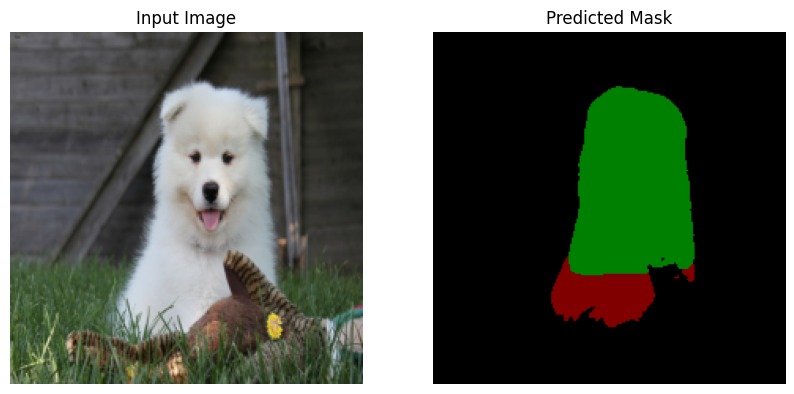

Text prompt: the dog sitting down


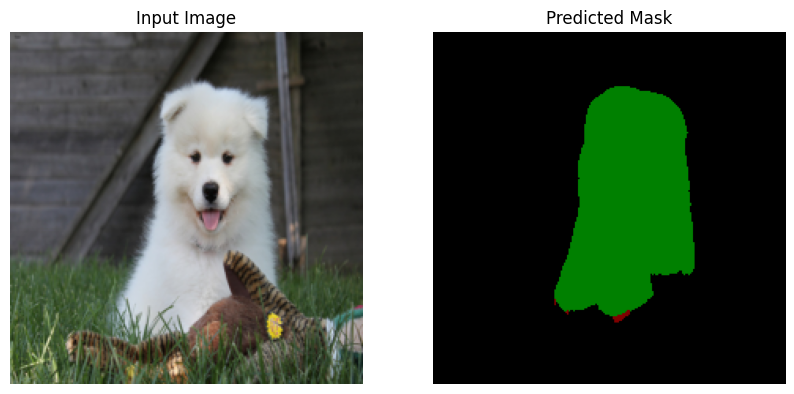

Text prompt: the cat sitting down


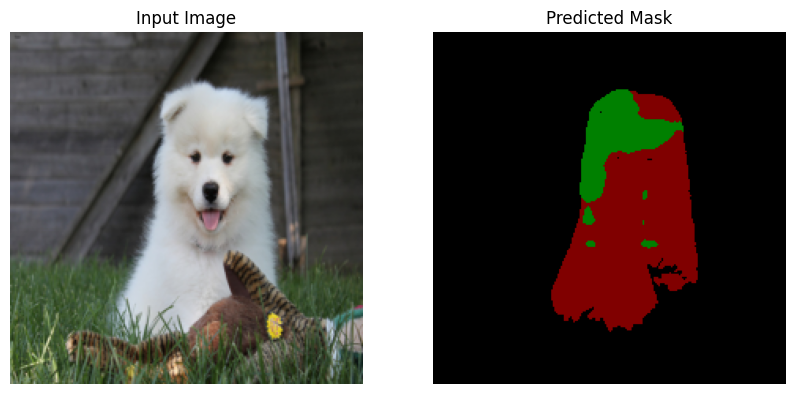

Text prompt: the background without animals


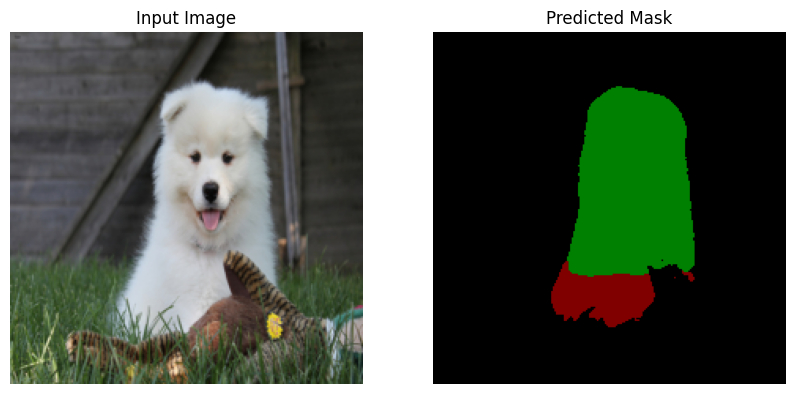

In [49]:
image_path = "../Dataset/Test/color/samoyed_25.jpg"

text_prompt = ""
print("Text prompt:", text_prompt)
image, mask = predict_mask(model, clip_model, image_path, text_prompt, device)
visualize_prediction(image_path, mask)

text_prompt = "the dog sitting down"
print("Text prompt:", text_prompt)
image, mask = predict_mask(model, clip_model, image_path, text_prompt, device)
visualize_prediction(image_path, mask)

text_prompt = "the cat sitting down"
print("Text prompt:", text_prompt)
image, mask = predict_mask(model, clip_model, image_path, text_prompt, device)
visualize_prediction(image_path, mask)

text_prompt = "the background without animals"
print("Text prompt:", text_prompt)
image, mask = predict_mask(model, clip_model, image_path, text_prompt, device)
visualize_prediction(image_path, mask)

Text prompt: 


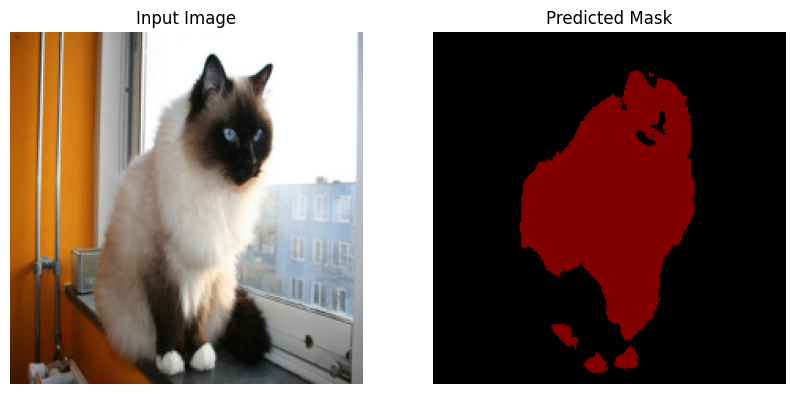

Text prompt: the dog by the window


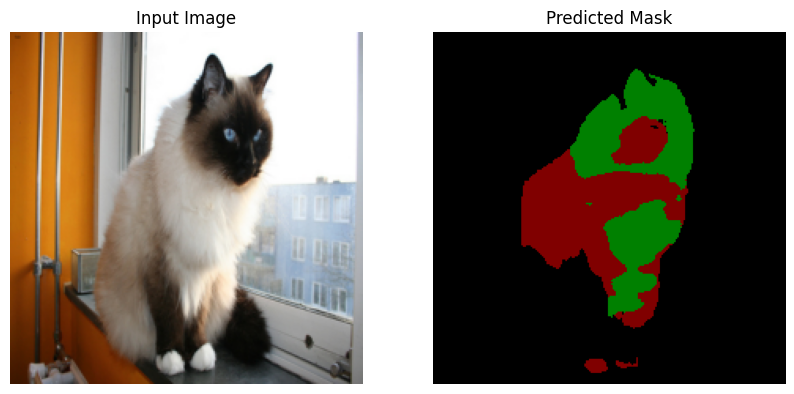

Text prompt: the cat by the window


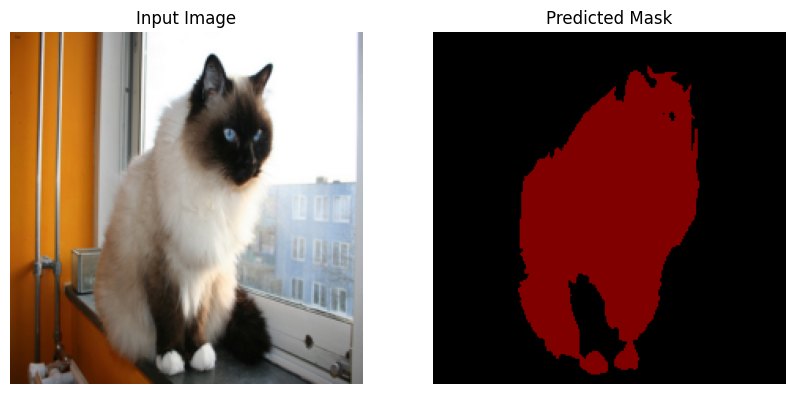

Text prompt: the background without animals


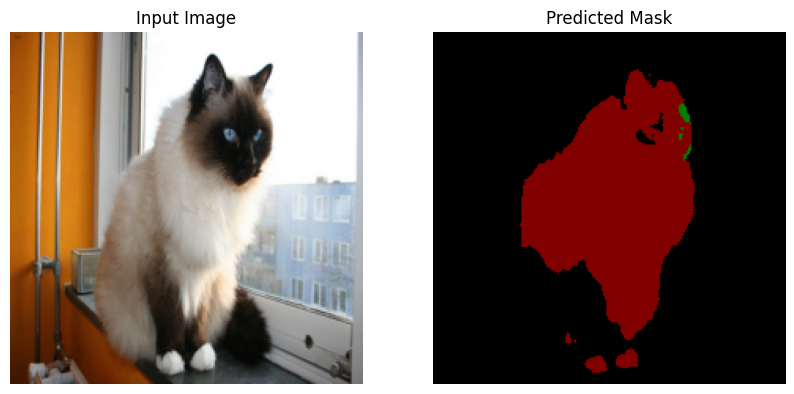

In [50]:
image_path = "../Dataset/Test/color/Birman_19.jpg"

text_prompt = ""
print("Text prompt:", text_prompt)
image, mask = predict_mask(model, clip_model, image_path, text_prompt, device)
visualize_prediction(image_path, mask)

text_prompt = "the dog by the window"
print("Text prompt:", text_prompt)
image, mask = predict_mask(model, clip_model, image_path, text_prompt, device)
visualize_prediction(image_path, mask)

text_prompt = "the cat by the window"
print("Text prompt:", text_prompt)
image, mask = predict_mask(model, clip_model, image_path, text_prompt, device)
visualize_prediction(image_path, mask)

text_prompt = "the background without animals"
print("Text prompt:", text_prompt)
image, mask = predict_mask(model, clip_model, image_path, text_prompt, device)
visualize_prediction(image_path, mask)